# This is a stupid idea but might be workable with a nonlinear fitting method. Basically assume that datapoints lie on a circle and find best (linear) projection of ports onto that circle. This way you just 'assume' the geometry of the task space

In [1]:
#%matplotlib inline
import sys
import os


import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import pandas as pd
import networkx as nx
import scipy.stats as stt
#optional for nicer plots
import seaborn
clrs = seaborn.color_palette(n_colors=6)
seaborn.set(style='ticks',font_scale=1.5)

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# UPDATE THE PATH BELOW TO THE CODE FOLDER

In [7]:
from mecll.plot import plot_activity_on_graph
from mecll.load import load_data
from mecll.process_data.proc_beh import build_poke_df

# Load stuff

In [2]:
def load_data(selected_session):
    
    """ Function to load data structured according to the format
        that the data were delivered to the retreat for
    """
    all_data_dir = '/Users/yves/Desktop/retreat_data_dir/data/'
    all_data_folders = sorted([i for i in os.listdir(all_data_dir) if 'ks25' in i])
    root_dir = os.path.join(all_data_dir,all_data_folders[selected_session])
    spkT = np.load(os.path.join(root_dir,'spkT_task.npy'))


    #This array is the same shape as spkT but shows which cluster each of the spikes in spkT belongs to
    spkC = np.load(os.path.join(root_dir,'spkC_task.npy'))

    #This is basically a big table (you can open it in excel) which contains
    #relevant information about each time the animal poked one of the ports
    task_event_df = pd.read_csv(os.path.join(root_dir,'task_event_table.csv'),index_col=0)

    #
    response_table = np.load(os.path.join(root_dir,'neuron_response_table.npy'))
    #alternatively to change the time window


    #not all cluster in spkC correspond to single units. Single units is an array of the clusters that are single units
    single_units = np.load(os.path.join(root_dir,'single_units.npy'))
    
    
    seq0 = np.array(eval(task_event_df.loc[task_event_df['task_nr']==0]['current_sequence'].values[0]))
    seq1 = np.array(eval(task_event_df.loc[task_event_df['task_nr']==1]['current_sequence'].values[0]))
    
    
    graph_type0 = task_event_df.loc[task_event_df['task_nr']==0]['graph_type'].values[0]
    graph_type1 = task_event_df.loc[task_event_df['task_nr']==0]['graph_type'].values[0]
    
    firing_rate_maps = get_task_responses(task_event_df,response_table)
    
    return firing_rate_maps, task_event_df

In [3]:
def get_task_responses(task_event_df,response_table):
    """ 
    Use the columns of the task_event_df to filter neural activity. 
    In this example build separate firing rate maps for each of the
    tasks, selecting only trials where subjects poked the correct poke.
    
    
    """
    
    
    n_neurons = response_table.shape[1]
    n_ports = 9
    n_tasks = 2
    n_direction = 2
    
    #set variables to nan to not confuse missing data for no responses
    firing_rate_maps = np.zeros([n_neurons,n_ports,n_tasks,n_direction]) + np.nan
    
    #for each task
    for task in np.unique(task_event_df['task_nr'].values):
        
        for port in range(n_ports):  #for each port
            
            for dix,direction in enumerate(np.unique(task_event_df['direction'].values)):

                #Select indices of pokes where...
                table_index = task_event_df.loc[(task_event_df['task_nr']==task) &  #task_nr was task
                                                (task_event_df['correct']==True) &  #the poke was to the correct port
                                                (task_event_df['port']==port) &       #the port poked was port
                                                (task_event_df['direction']==direction)
                                               ].index           
                #print(len(table_index))
                #get the average
                firing_rate_maps[:,int(port),int(task),dix] = np.nanmean(response_table[table_index],axis=0)
    return firing_rate_maps
                                         

# Load retreat data

In [8]:
firing_rate_maps, task_event_df = load_data(0)

seq0 = np.array(eval(task_event_df.loc[task_event_df['task_nr']==0]['current_sequence'].values[0]))
seq1 = np.array(eval(task_event_df.loc[task_event_df['task_nr']==1]['current_sequence'].values[0]))

graph_type0 = task_event_df.loc[task_event_df['task_nr']==0]['graph_type'].values[0]
graph_type1 = task_event_df.loc[task_event_df['task_nr']==1]['graph_type'].values[0]
print(graph_type0,graph_type1)

spatial_map  = np.nanmean(firing_rate_maps,axis=(2,3))
mds_frm = firing_rate_maps - spatial_map[:,:,None,None]
#valid_ix = np.where(~np.isnan(np.sum(firing_rate_maps,axis=(0,2,3))))[0]
frm = np.hstack([mds_frm[:,seq0,0,0],mds_frm[:,seq0,0,1],mds_frm[:,seq1,1,0],mds_frm[:,seq1,1,1]])

loop loop


In [7]:
seq1

array('[1, 3, 6, 0, 2, 8, 4, 7, 5]', dtype='<U27')

In [25]:
np.corrcoef(np.sin(np.linspace(0,2*np.pi,9)),
           np.sin(np.linspace(0,4*np.pi,9)))

array([[ 1.00000000e+00, -5.55111512e-17],
       [-5.55111512e-17,  1.00000000e+00]])

In [26]:
state_representation = np.vstack([np.sin(np.linspace(0,1,num=9)*6*np.pi),  # three laps around circle in state
                                  np.cos(np.linspace(0,1,num=9)*6*np.pi),
                                  
                                  np.sin(np.linspace(0,1,num=9)*2*np.pi),  # one lap around circle
                                  np.cos(np.linspace(0,1,num=9)*2*np.pi)
                                  ]
                                 )

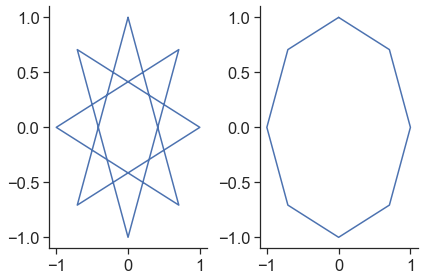

In [27]:
# visualise the state representation

plt.subplot(1,2,1)
plt.plot(state_representation[0],state_representation[1])

plt.subplot(1,2,2)
plt.plot(state_representation[2],state_representation[3])

plt.tight_layout()
seaborn.despine()

In [28]:
state_representation.shape

(4, 9)

In [29]:
from sklearn.metrics import explained_variance_score

In [30]:
sr2 = frm[:,27:]

NameError: name 'frm' is not defined

In [31]:
# Here actually fit data to the circle
shuff_ccs = []
for _ in range(10000):
    y = sr2[:,np.random.permutation(np.arange(9))].T
    #y = sr2.T
    X = np.hstack([np.ones([1,9]).T,state_representation.T.copy()])
    b,residuals,rank,singular_vals = np.linalg.lstsq(X,y,rcond=None)
    binv = np.linalg.pinv(b)

    #evar = 1-np.var(np.dot(X,b)-y)/np.var(y)
    evar =  explained_variance_score(y_true=y,y_pred=np.dot(X,b))#1-np.nanmean(np.var(np.dot(X,b)-y,axis=0)/np.var(y,axis=0))
    shuff_ccs.append(evar)

y = sr2.T
X = np.hstack([np.ones([1,9]).T,state_representation.T.copy()])
b,residuals,rank,singular_vals = np.linalg.lstsq(X,y,rcond=None)
binv = np.linalg.pinv(b)

#true_evar = 1-np.var(np.dot(X,b)-y)/np.var(y)
true_evar = explained_variance_score(y_true=y,y_pred=np.dot(X,b))#1-np.nanmean(np.var(np.dot(X,b)-y,axis=0)/np.var(y,axis=0))
print(true_evar)


0.27149475933123873


In [32]:
#np.nanmean(np.var(np.dot(X,b)-y,axis=0)/np.var(y,axis=0))

In [23]:
x = np.random.normal(size=(100))

71.77


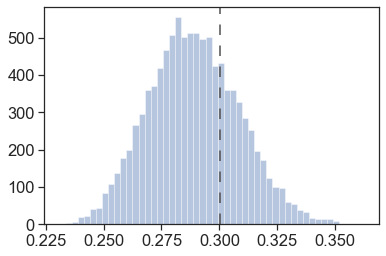

In [24]:
seaborn.distplot(shuff_ccs,kde=0)
plt.axvline(x=true_evar,dashes=(7,7),color='.3')
print(stt.percentileofscore(shuff_ccs,true_evar))

In [25]:
binv = np.linalg.pinv(b)
plt.plot(binv.dot(state_representation)[0],binv.dot(state_representation)[1])

ValueError: shapes (135,5) and (4,9) not aligned: 5 (dim 1) != 4 (dim 0)

# Run across all sessions

In [363]:
all_across_task_fits = []
for session_ix in range(8):

    firing_rate_maps, task_event_df = load_data(session_ix)
    #frm_task = firing_rate_maps[:,:,1]
    #frm_task2 = firing_rate_maps[:,:,0]
    spatial_map  = np.nanmean(firing_rate_maps,axis=(2,3))
    frm = np.hstack([mds_frm[:,valid_ix,0,0],mds_frm[:,valid_ix,0,1],mds_frm[:,seq1,1,0],mds_frm[:,seq1,1,1]])
    #pca = PCA(n_components=12)
    #pca.fit(frm.T)
    
    mds_frm = firing_rate_maps - spatial_map[:,:,None,None]
    valid_ix = np.where(~np.isnan(np.sum(firing_rate_maps,axis=(0,2,3))))[0]
    
    #X_train = np.hstack([frm_task[:,valid_ix,0],frm_task[:,valid_ix,1]])
    #X_test =  np.hstack([frm_task2[:,valid_ix,0],frm_task2[:,valid_ix,1]])

    mds_frm_flat = np.hstack([mds_frm[:,valid_ix,0,0],mds_frm[:,valid_ix,0,1]])#,mds_frm[:,seq1,1,0],mds_frm[:,seq1,1,1]])
    mds_frm_flat2 = np.hstack([mds_frm[:,valid_ix,1,0],mds_frm[:,valid_ix,1,1]])
    all_across_task_fits.append(run_LDA(mds_frm_flat,mds_frm_flat2))

                                

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/Users/yves/op